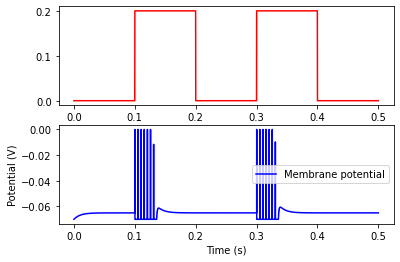

[-0.07  -0.07  -0.07  ... -0.065 -0.065 -0.065]


In [3]:
#Default settings
import sys
import os
import moose
import matplotlib.pyplot as plt
import numpy as np

def setupmodel(modelpath, iaf_Rm, iaf_Cm, pulse_interval):

    model = moose.Neutral(modelpath)
    data = moose.Neutral(datapath)
    iaf = moose.LIF('%s/iaf' % (modelpath))
    iaf.Rm = iaf_Rm
    iaf.Cm = iaf_Cm
    iaf.initVm = -0.070
    iaf.Em = -0.065
    iaf.vReset = -0.07
    iaf.thresh = -0.055
    iaf.refractoryPeriod = 0.005
    syn = moose.SynChan('%s/syn' % (iaf.path))
    syns = moose.SimpleSynHandler( syn.path + '/syns' )
    moose.connect( syns, 'activationOut', syn, 'activation' )
    
    syns.synapse.num = 4
    syns.synapse[0].delay = 0.01
        
    syn.Ek = 0.0
    syn.Gbar = 1.0
    moose.connect(syn, 'channel', iaf, 'channel')
    moose.connect(iaf, 'VmOut', syn, 'Vm')
    
    
    sg = moose.SpikeGen('%s/spike' % (modelpath))
    sg.threshold = 0.1
    
    for i in range(0,4):
        moose.connect(sg, 'spikeOut', syns.synapse[i], 'addSpike')
    
    #pulse
    pulse = moose.PulseGen('%s/pulse' % (modelpath))
    pulse.count = 1
    for i in range(0, 1):
        pulse.delay[i] = pulse_interval
        pulse.width[i] = 1e-1
        pulse.level[i] = 0.2
        
    moose.connect(pulse, 'output', sg, 'Vm')
    return {
        'model': model,
        'iaf': iaf,
        'synchan': syn,
        'spikegen': sg,
        'pulsegen': pulse
        }


if __name__ == '__main__':
    modelpath = '/lif_demo'
    datapath = '/data'
    simtime = 0.5
    setup = setupmodel(modelpath, 127e6, 7.8e-11, 0.1)
    
    # Setup data recording
    data = moose.Neutral(datapath)
    vm_table = moose.Table('%s/vm' % (data.path))
    
    moose.connect(vm_table, 'requestOut', setup['iaf'], 'getVm')
    spike_table = moose.Table('%s/spike' % (data.path))

    pulse_table = moose.Table('%s/pulse' % (data.path))
    moose.connect(pulse_table, 'requestOut', setup['pulsegen'], 'getOutputValue')
    
    gsyn_table = moose.Table('%s/gk' % (datapath))
    moose.connect(gsyn_table, 'requestOut', setup['synchan'], 'getIk')
    
    # Schedule model components for simulation
    moose.setClock(0, 1e-4)
    moose.setClock(1, 1e-4)
    moose.setClock(2, 1e-4)
    moose.setClock(3, 1e-4)
    moose.useClock(0, '%s,%s' % (setup['pulsegen'].path, setup['spikegen'].path), 'process')
    moose.useClock(1, setup['synchan'].path, 'process')
    moose.useClock(2, setup['iaf'].path, 'process')
    moose.useClock(3, '%s/##' % (datapath), 'process')
    
    # run simulation
    moose.reinit()
    moose.start(simtime)
    t = np.linspace(0, simtime, len(pulse_table.vector))
    f,ax = plt.subplots(2,1)
  
    ax[1].plot(t, vm_table.vector, 'b', label='Membrane potential')
    ax[0].plot(t, pulse_table.vector, 'r', label='Input pulse')
    #plt.plot(t, gsyn_table.vector, 'c', label='Isyn')
    plt.legend()
    plt.ylabel("Potential (V)")
    plt.xlabel("Time (s)")
    plt.show()
    print(vm_table.vector)

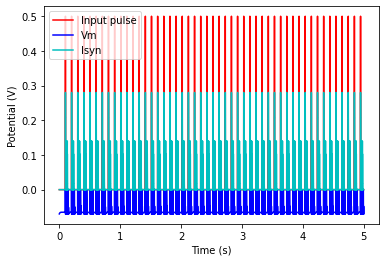

[-0.07       -0.07       -0.06994978 ... -0.07       -0.07
 -0.07      ]


In [2]:
#Increasing number of synapses
import sys
import os
import moose
import matplotlib.pyplot as plt
import numpy as np

def setupmodel(modelpath, iaf_Rm, iaf_Cm, pulse_interval):

    model = moose.Neutral(modelpath)
    data = moose.Neutral(datapath)
    iaf = moose.LIF('%s/iaf' % (modelpath))
    iaf.Rm = iaf_Rm
    iaf.Cm = iaf_Cm
    iaf.initVm = -0.070
    iaf.Em = -0.065
    #iaf.Vreset = -0.070
    iaf.thresh = -0.055
    # iaf.refractoryPeriod = 0.005
    syn = moose.SynChan('%s/syn' % (iaf.path))
    syns = moose.SimpleSynHandler( syn.path + '/syns' )
    moose.connect( syns, 'activationOut', syn, 'activation' )
    
    syns.synapse.num = 50
    for i in range(0,50):
        syns.synapse[i].delay = i*0.01
        
    syn.Ek = 0.0
    syn.Gbar = 1.0
    moose.connect(syn, 'channel', iaf, 'channel')
    moose.connect(iaf, 'VmOut', syn, 'Vm')
    
    
    sg = moose.SpikeGen('%s/spike' % (modelpath))
    sg.threshold = 0.1
    moose.connect(sg, 'spikeOut', syns.synapse[0], 'addSpike')
    
    #pulse
    pulse = moose.PulseGen('%s/pulse' % (modelpath))
    pulse.count = 1
    for i in range(0, 1):
        pulse.delay[i] = pulse_interval
        pulse.width[i] = 1e-3
        pulse.level[i] = 0.5
        
    moose.connect(pulse, 'output', sg, 'Vm')
    return {
        'model': model,
        'iaf': iaf,
        'synchan': syn,
        'spikegen': sg,
        'pulsegen': pulse
        }


if __name__ == '__main__':
    modelpath = '/lif_demo'
    datapath = '/data'
    simtime = 5.0
    setup = setupmodel(modelpath, 127e6, 7.8e-11, 0.1)
    
    # Setup data recording
    data = moose.Neutral(datapath)
    vm_table = moose.Table('%s/vm' % (data.path))
    
    moose.connect(vm_table, 'requestOut', setup['iaf'], 'getVm')
    spike_table = moose.Table('%s/spike' % (data.path))

    pulse_table = moose.Table('%s/pulse' % (data.path))
    moose.connect(pulse_table, 'requestOut', setup['pulsegen'], 'getOutputValue')
    
    gsyn_table = moose.Table('%s/gk' % (datapath))
    moose.connect(gsyn_table, 'requestOut', setup['synchan'], 'getIk')
    
    # Schedule model components for simulation
    moose.setClock(0, 1e-4)
    moose.setClock(1, 1e-4)
    moose.setClock(2, 1e-4)
    moose.setClock(3, 1e-4)
    moose.useClock(0, '%s,%s' % (setup['pulsegen'].path, setup['spikegen'].path), 'process')
    moose.useClock(1, setup['synchan'].path, 'process')
    moose.useClock(2, setup['iaf'].path, 'process')
    moose.useClock(3, '%s/##' % (datapath), 'process')
    
    # run simulation
    moose.reinit()
    moose.start(simtime)
    t = np.linspace(0, simtime, len(pulse_table.vector))
    plt.plot(t, pulse_table.vector, 'r', label='Input pulse')
    plt.plot(t, vm_table.vector, 'b', label='Vm')
    plt.plot(t, gsyn_table.vector, 'c', label='Isyn')
    plt.legend()
    plt.ylabel("Potential (V)")
    plt.xlabel("Time (s)")
    plt.show()
    print(vm_table.vector)
 

In [ ]:
#Increasing number of pulses
import sys
import os
import moose
import matplotlib.pyplot as plt
import numpy as np

def setupmodel(modelpath, iaf_Rm, iaf_Cm, pulse_interval):

    model = moose.Neutral(modelpath)
    data = moose.Neutral(datapath)
    iaf = moose.LIF('%s/iaf' % (modelpath))
    iaf.Rm = iaf_Rm
    iaf.Cm = iaf_Cm
    iaf.initVm = -0.070
    iaf.Em = -0.065
    #iaf.Vreset = -0.070
    iaf.thresh = -0.055
    # iaf.refractoryPeriod = 0.005
    syn = moose.SynChan('%s/syn' % (iaf.path))
    syns = moose.SimpleSynHandler( syn.path + '/syns' )
    moose.connect( syns, 'activationOut', syn, 'activation' )
    
    syns.synapse.num = 1
    syns.synapse[0].delay = 0.01
        
    syn.Ek = 0.0
    syn.Gbar = 1.0
    moose.connect(syn, 'channel', iaf, 'channel')
    moose.connect(iaf, 'VmOut', syn, 'Vm')
    
    
    sg = moose.SpikeGen('%s/spike' % (modelpath))
    sg.threshold = 0.1
    moose.connect(sg, 'spikeOut', syns.synapse[0], 'addSpike')
    
    #pulse
    pulse = moose.PulseGen('%s/pulse' % (modelpath))
    pulse.count = 50
    for i in range(0, 50):
        pulse.delay[i] = pulse_interval
        pulse.width[i] = 1e-3
        pulse.level[i] = 0.5
        
    moose.connect(pulse, 'output', sg, 'Vm')
    return {
        'model': model,
        'iaf': iaf,
        'synchan': syn,
        'spikegen': sg,
        'pulsegen': pulse
        }


if __name__ == '__main__':
    modelpath = '/lif_demo'
    datapath = '/data'
    simtime = 5.0
    setup = setupmodel(modelpath, 127e6, 7.8e-11, 0.1)
    
    # Setup data recording
    data = moose.Neutral(datapath)
    vm_table = moose.Table('%s/vm' % (data.path))
    
    moose.connect(vm_table, 'requestOut', setup['iaf'], 'getVm')
    spike_table = moose.Table('%s/spike' % (data.path))

    pulse_table = moose.Table('%s/pulse' % (data.path))
    moose.connect(pulse_table, 'requestOut', setup['pulsegen'], 'getOutputValue')
    
    gsyn_table = moose.Table('%s/gk' % (datapath))
    moose.connect(gsyn_table, 'requestOut', setup['synchan'], 'getIk')
    
    # Schedule model components for simulation
    moose.setClock(0, 1e-4)
    moose.setClock(1, 1e-4)
    moose.setClock(2, 1e-4)
    moose.setClock(3, 1e-4)
    moose.useClock(0, '%s,%s' % (setup['pulsegen'].path, setup['spikegen'].path), 'process')
    moose.useClock(1, setup['synchan'].path, 'process')
    moose.useClock(2, setup['iaf'].path, 'process')
    moose.useClock(3, '%s/##' % (datapath), 'process')
    
    # run simulation
    moose.reinit()
    moose.start(simtime)
    t = np.linspace(0, simtime, len(pulse_table.vector))
    plt.plot(t, pulse_table.vector, 'r', label='Input pulse')
    plt.plot(t, vm_table.vector, 'b', label='Vm')
    plt.plot(t, gsyn_table.vector, 'c', label='Isyn')
    plt.legend()
    plt.ylabel("Potential (V)")
    plt.xlabel("Time (s)")
    plt.show()
    print(vm_table.vector)

In [ ]:
#Decreasing pulse width
import sys
import os
import moose
import matplotlib.pyplot as plt
import numpy as np

def setupmodel(modelpath, iaf_Rm, iaf_Cm, pulse_interval):

    model = moose.Neutral(modelpath)
    data = moose.Neutral(datapath)
    iaf = moose.LIF('%s/iaf' % (modelpath))
    iaf.Rm = iaf_Rm
    iaf.Cm = iaf_Cm
    iaf.initVm = -0.070
    iaf.Em = -0.065
    #iaf.Vreset = -0.070
    iaf.thresh = -0.055
    # iaf.refractoryPeriod = 0.005
    syn = moose.SynChan('%s/syn' % (iaf.path))
    syns = moose.SimpleSynHandler( syn.path + '/syns' )
    moose.connect( syns, 'activationOut', syn, 'activation' )
    
    syns.synapse.num = 1
    syns.synapse[0].delay = 0.01
        
    syn.Ek = 0.0
    syn.Gbar = 1.0
    moose.connect(syn, 'channel', iaf, 'channel')
    moose.connect(iaf, 'VmOut', syn, 'Vm')
    
    
    sg = moose.SpikeGen('%s/spike' % (modelpath))
    sg.threshold = 0.1
    moose.connect(sg, 'spikeOut', syns.synapse[0], 'addSpike')
    
    #pulse
    pulse = moose.PulseGen('%s/pulse' % (modelpath))
    pulse.count = 1
    for i in range(0, 1):
        pulse.delay[i] = pulse_interval
        pulse.width[i] = 1e-4
        pulse.level[i] = 0.5
        
    moose.connect(pulse, 'output', sg, 'Vm')
    return {
        'model': model,
        'iaf': iaf,
        'synchan': syn,
        'spikegen': sg,
        'pulsegen': pulse
        }


if __name__ == '__main__':
    modelpath = '/lif_demo'
    datapath = '/data'
    simtime = 5.0
    setup = setupmodel(modelpath, 127e6, 7.8e-11, 0.1)
    
    # Setup data recording
    data = moose.Neutral(datapath)
    vm_table = moose.Table('%s/vm' % (data.path))
    
    moose.connect(vm_table, 'requestOut', setup['iaf'], 'getVm')
    spike_table = moose.Table('%s/spike' % (data.path))

    pulse_table = moose.Table('%s/pulse' % (data.path))
    moose.connect(pulse_table, 'requestOut', setup['pulsegen'], 'getOutputValue')
    
    gsyn_table = moose.Table('%s/gk' % (datapath))
    moose.connect(gsyn_table, 'requestOut', setup['synchan'], 'getIk')
    
    # Schedule model components for simulation
    moose.setClock(0, 1e-4)
    moose.setClock(1, 1e-4)
    moose.setClock(2, 1e-4)
    moose.setClock(3, 1e-4)
    moose.useClock(0, '%s,%s' % (setup['pulsegen'].path, setup['spikegen'].path), 'process')
    moose.useClock(1, setup['synchan'].path, 'process')
    moose.useClock(2, setup['iaf'].path, 'process')
    moose.useClock(3, '%s/##' % (datapath), 'process')
    
    # run simulation
    moose.reinit()
    moose.start(simtime)
    t = np.linspace(0, simtime, len(pulse_table.vector))
    plt.plot(t, pulse_table.vector, 'r', label='Input pulse')
    plt.plot(t, vm_table.vector, 'b', label='Vm')
    plt.plot(t, gsyn_table.vector, 'c', label='Isyn')
    plt.legend()
    plt.ylabel("Potential (V)")
    plt.xlabel("Time (s)")
    plt.show()
    print(vm_table.vector)

In [ ]:
#Decreasing pulse level

import sys
import os
import moose
import matplotlib.pyplot as plt
import numpy as np

def setupmodel(modelpath, iaf_Rm, iaf_Cm, pulse_interval):

    model = moose.Neutral(modelpath)
    data = moose.Neutral(datapath)
    iaf = moose.LIF('%s/iaf' % (modelpath))
    iaf.Rm = iaf_Rm
    iaf.Cm = iaf_Cm
    iaf.initVm = -0.070
    iaf.Em = -0.065
    #iaf.Vreset = -0.070
    iaf.thresh = -0.055
    # iaf.refractoryPeriod = 0.005
    syn = moose.SynChan('%s/syn' % (iaf.path))
    syns = moose.SimpleSynHandler( syn.path + '/syns' )
    moose.connect( syns, 'activationOut', syn, 'activation' )
    
    syns.synapse.num = 1
    syns.synapse[0].delay = 0.01
        
    syn.Ek = 0.0
    syn.Gbar = 1.0
    moose.connect(syn, 'channel', iaf, 'channel')
    moose.connect(iaf, 'VmOut', syn, 'Vm')
    
    
    sg = moose.SpikeGen('%s/spike' % (modelpath))
    sg.threshold = 0.1
    moose.connect(sg, 'spikeOut', syns.synapse[0], 'addSpike')
    
    #pulse
    pulse = moose.PulseGen('%s/pulse' % (modelpath))
    pulse.count = 1
    for i in range(0, 1):
        pulse.delay[i] = pulse_interval
        pulse.width[i] = 1e-3
        pulse.level[i] = 0.1
        
    moose.connect(pulse, 'output', sg, 'Vm')
    return {
        'model': model,
        'iaf': iaf,
        'synchan': syn,
        'spikegen': sg,
        'pulsegen': pulse
        }


if __name__ == '__main__':
    modelpath = '/lif_demo'
    datapath = '/data'
    simtime = 5.0
    setup = setupmodel(modelpath, 127e6, 7.8e-11, 0.1)
    
    # Setup data recording
    data = moose.Neutral(datapath)
    vm_table = moose.Table('%s/vm' % (data.path))
    
    moose.connect(vm_table, 'requestOut', setup['iaf'], 'getVm')
    spike_table = moose.Table('%s/spike' % (data.path))

    pulse_table = moose.Table('%s/pulse' % (data.path))
    moose.connect(pulse_table, 'requestOut', setup['pulsegen'], 'getOutputValue')
    
    gsyn_table = moose.Table('%s/gk' % (datapath))
    moose.connect(gsyn_table, 'requestOut', setup['synchan'], 'getIk')
    
    # Schedule model components for simulation
    moose.setClock(0, 1e-4)
    moose.setClock(1, 1e-4)
    moose.setClock(2, 1e-4)
    moose.setClock(3, 1e-4)
    moose.useClock(0, '%s,%s' % (setup['pulsegen'].path, setup['spikegen'].path), 'process')
    moose.useClock(1, setup['synchan'].path, 'process')
    moose.useClock(2, setup['iaf'].path, 'process')
    moose.useClock(3, '%s/##' % (datapath), 'process')
    
    # run simulation
    moose.reinit()
    moose.start(simtime)
    t = np.linspace(0, simtime, len(pulse_table.vector))
    plt.plot(t, pulse_table.vector, 'r', label='Input pulse')
    plt.plot(t, vm_table.vector, 'b', label='Vm')
    plt.plot(t, gsyn_table.vector, 'c', label='Isyn')
    plt.legend()
    plt.ylabel("Potential (V)")
    plt.xlabel("Time (s)")
    plt.show()
    print(vm_table.vector)